In [1]:
from pathlib import Path

TRAIN_MANIFEST = "data/manifests/irmas_train_mels.csv"

EPOCHS = 200
BATCH_SIZE = 32
LR = 3e-4
WEIGHT_DECAY = 1e-4
VAL_FRAC = 0.15
DROPOUT = 0.5
PATIENCE = 50
NUM_WORKERS = 2
SEED = 1337

RESUME = True # loads previous model weights, set to False if training from scratch
TRAIN_NUMBER = "train_2" # directory to add  weights, change on each training run
CKPT_DIR = Path(f"saved_weights/irmas_pretrain_single_class/{TRAIN_NUMBER}")
RESUME_CKPT = (CKPT_DIR / "last.pt") if RESUME else None  # or CKPT_DIR/"best_val_acc.pt"

In [2]:
from src.utils.datasets import SingleClassMelNpyDataset
from train_utils import train_loop
out = train_loop(
    train_manifest=TRAIN_MANIFEST,
    ckpt_dir=CKPT_DIR,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    val_frac=VAL_FRAC,
    dropout=DROPOUT,
    patience=PATIENCE,
    num_workers=NUM_WORKERS,
    seed=SEED,
    resume_from=RESUME_CKPT,
    save_best_stamped=True,
)
history = out["history"]

NameError: name 'List' is not defined

['train_loss', 'train_acc', 'val_loss', 'val_acc']


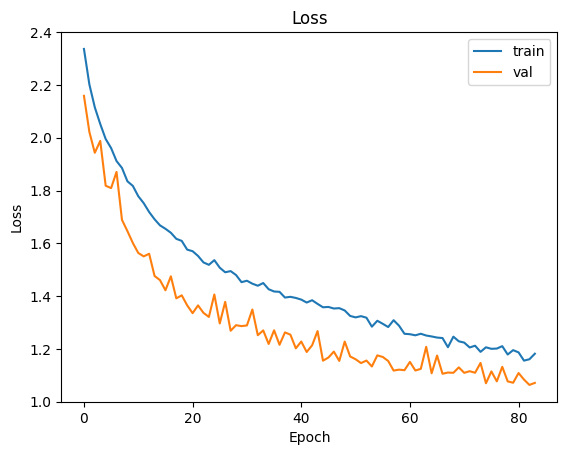

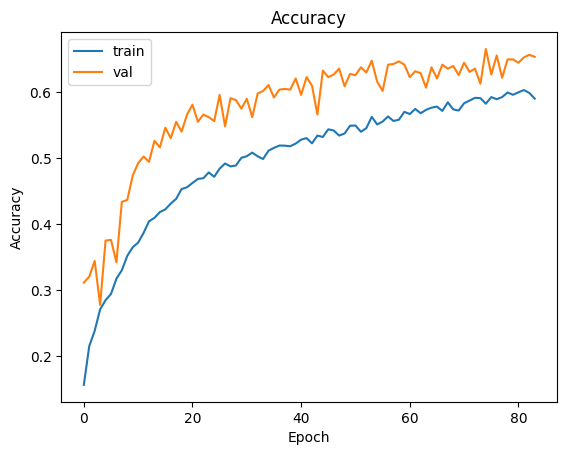

In [ ]:

import matplotlib.pyplot as plt
import torch


CKPT = RESUME_CKPT = (CKPT_DIR / "last.pt")
# CKPT = 'saved_weights/irmas_pretrain_single_class/train_1/best_val_acc_junran_0.72.pt' # example of loading a different checkpoint

ckpt_loaded = torch.load(CKPT, map_location="cpu")
history = ckpt_loaded["history"]
print(list(history.keys()))  



plt.figure()
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss"); plt.legend(); plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train")
plt.plot(history["val_acc"], label="val")
plt.xlabel("Epoch") 
plt.ylabel("Accuracy")
plt.title("Accuracy"); plt.legend(); plt.show()

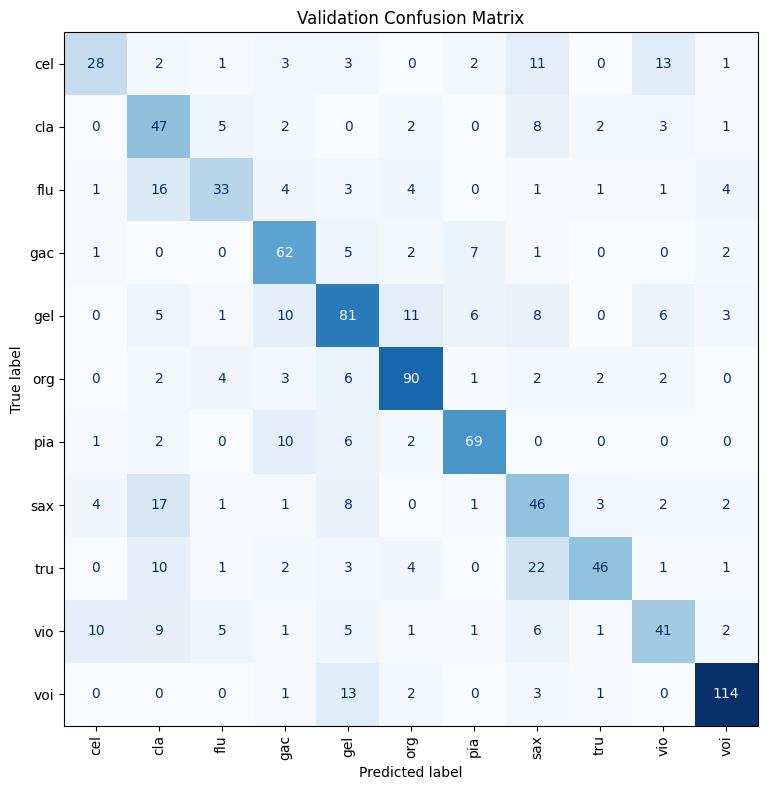

              precision    recall  f1-score   support

         cel     0.6222    0.4375    0.5138        64
         cla     0.4273    0.6714    0.5222        70
         flu     0.6471    0.4853    0.5546        68
         gac     0.6263    0.7750    0.6927        80
         gel     0.6090    0.6183    0.6136       131
         org     0.7627    0.8036    0.7826       112
         pia     0.7931    0.7667    0.7797        90
         sax     0.4259    0.5412    0.4767        85
         tru     0.8214    0.5111    0.6301        90
         vio     0.5942    0.5000    0.5430        82
         voi     0.8769    0.8507    0.8636       134

    accuracy                         0.6531      1006
   macro avg     0.6551    0.6328    0.6339      1006
weighted avg     0.6727    0.6531    0.6543      1006



In [ ]:
from pathlib import Path
import torch, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from src.models import CNNVarTime
from train_utils import seed_everything, get_device_and_amp, build_dataloaders


device = 'cpu'
pin_mem = False

label_to_idx = ckpt_loaded["label_to_idx"]
idx_to_label = [c for c, i in sorted(label_to_idx.items(), key=lambda kv: kv[1])]
num_classes = len(idx_to_label)

# rebuild val loader with same mapping (same split via same seed) 
_, val_loader, _ = build_dataloaders(
    manifest_csv=TRAIN_MANIFEST,
    val_frac=VAL_FRAC,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=pin_mem,
    seed=SEED,
    label_to_idx=label_to_idx,  
)

#  build model and load weights (strict) 
model = CNNVarTime(in_ch=2, num_classes=num_classes, p_drop=0.5).to(device)
model.load_state_dict(ckpt_loaded["model_state"], strict=True)
model.eval()

# predict validation set
all_y_true, all_y_pred = [], []
with torch.no_grad():
    for X, y in val_loader:
        X = X.to(device, non_blocking=pin_mem)
        logits = model(X)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_y_pred.extend(preds)
        all_y_true.extend(y.numpy())


cm = confusion_matrix(all_y_true, all_y_pred, labels=list(range(num_classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=idx_to_label)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap="Blues", ax=ax, colorbar=False, xticks_rotation=90)
ax.set_title("Validation Confusion Matrix")
plt.tight_layout(); plt.show()

# ---- classification report ----
print(classification_report(all_y_true, all_y_pred, target_names=idx_to_label, digits=4))